# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone - IBM Data Science Professional Certificate Course - COURSERA



## 1. Introduction: Business Problem <a name="introduction"></a>

New York City is probably one of the most multietnic places in the World. This great 

The aim of this project is to find the optimal location for a new restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Italian restaurant** in **New York City**, USA.

The factors we have to take into account when deciding where open a new restaurant are: 
* Market Places.
* Competition in particular location.
* Aiding places that make people come to restaurants like Gym, Pubs, Parks and more. 
* Population.
* Menu of competitors. 

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.


## 2.  Required Data <a name="data"></a>

For this project we need New York Neighborhood Data which will be used to get to know about the various neighborhoods which are gonna take into consideration. 
* Data source: https://geo.nyu.edu/catalog/nyu_2451_34572

Geo-spacial data of the New York to get a better understanding of the neighborhoods in it and their corresponding locations in the Folium map would make certain things clear for the Project. This will be achieved using the acquired data and visualize the same using Choropleth maps.
* Data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

Finally the data going to be collected/acquired from the Foursquare API about the various restaurants in each neighborhood of New York city especially Italian cuisine, which will be used for acquiring the information regarding same for all the venues of each neighborhood.
* Data source: https://foursquare.com/

## Exploratory Data Analysis

###  Relationship between the neighborhood and the restaurant. 
Firt, import all the required libraries. 

In [1]:
import pandas as pd
import numpy as np
import requests
import os

import folium # For rendering maps

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # Acquiring latitude and longitude

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Imported Libraries.')

Solving environment: ...working... done

# All requested packages already installed.

Imported Libraries.


In [2]:
#Define a function to create a data set about New York  from the acquired data. 

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [3]:
df_ny = get_new_york_data()

In [4]:
df_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
df_ny.shape

(306, 4)

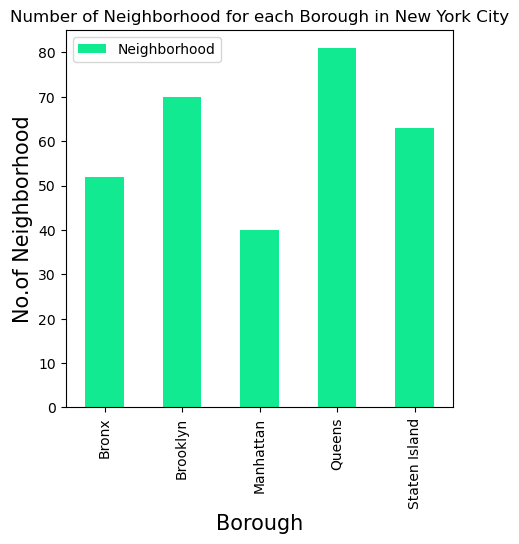

In [6]:
#Initially we want to know about the various neighborhoods in NYC

plt.figure(figsize=(5,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df_ny.groupby('Borough')['Neighborhood'].count().plot(kind='bar', color='#12EA92')
#legend
plt.legend()
#displays the plot
plt.show()


In [7]:
#define a funcion for acquiring the latitude and the longitude from the provided location

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [8]:
#define a function to get the details of the venue by accessing the Foursquare API

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'F2NIXHCXKDNEUOI45KWOAYS4MJ3XXMYRLWSYHWFURXLVSC4I' # your Foursquare ID
    CLIENT_SECRET = 'YEELE2D4IKHZIV3QX0OJGHYVAF3IBWS5ZQWO1DNZJDFJ0MXZ' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
        
    CLIENT_ID = 'F2NIXHCXKDNEUOI45KWOAYS4MJ3XXMYRLWSYHWFURXLVSC4I' # your Foursquare ID
    CLIENT_SECRET = 'YEELE2D4IKHZIV3QX0OJGHYVAF3IBWS5ZQWO1DNZJDFJ0MXZ' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [9]:
#Get a list of Italian cousins in NYC

vns = get_venues(40.898273,-73.867315)
vns[vns['Category']=='Italian Restaurant']

,ID,Name,Category
2,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,Italian Restaurant


In [10]:
ita_res = vns[vns['Category']=='Italian Restaurant'].values.tolist()
ita_res

[['511edb6de4b0d58346fd272d', "Patrizia's Of Woodlawn", 'Italian Restaurant']]

In [11]:
len(vns[vns['Category']=='Italian Restaurant'].values.tolist()) > 0

True

In [12]:
for row in df_ny.values.tolist():
    print(row)

642974207]
['Bronx', 'Baychester', 40.866858107252696, -73.83579759808117]
['Bronx', 'Pelham Parkway', 40.85741349808865, -73.85475564017999]
['Bronx', 'City Island', 40.84724670491813, -73.78648845267413]
['Bronx', 'Bedford Park', 40.870185164975325, -73.8855121841913]
['Bronx', 'University Heights', 40.85572707719664, -73.9104159619131]
['Bronx', 'Morris Heights', 40.84789792606271, -73.91967159119565]
['Bronx', 'Fordham', 40.86099679638654, -73.89642655981623]
['Bronx', 'East Tremont', 40.84269615786053, -73.88735617532338]
['Bronx', 'West Farms', 40.83947505672653, -73.87774474910545]
['Bronx', 'High  Bridge', 40.836623010706056, -73.9261020935813]
['Bronx', 'Melrose', 40.819754370594936, -73.90942160757436]
['Bronx', 'Mott Haven', 40.80623874935177, -73.91609987487575]
['Bronx', 'Port Morris', 40.801663627756206, -73.91322139386135]
['Bronx', 'Longwood', 40.81509904545822, -73.8957882009446]
['Bronx', 'Hunts Point', 40.80972987938709, -73.88331505955291]
['Bronx', 'Morrisania', 40

In [18]:
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)

print('Italian restaurants in\n---------------------')
       
for row in df_ny.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']
    if len(italian_resturants) > 0:
        print(Neighborhood+', '+Borough+' : '+str(len(italian_resturants)))
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

print('Completed constructing the Italian cuisine restaurants data set')

Italian restaurants in
---------------------
Riverdale, Bronx : 1
Kingsbridge, Bronx : 1
Woodlawn, Bronx : 1
Baychester, Bronx : 2
Pelham Parkway, Bronx : 3
City Island, Bronx : 3
Bedford Park, Bronx : 1
Fordham, Bronx : 10
Melrose, Bronx : 2
Mott Haven, Bronx : 1
Morrisania, Bronx : 1
Throgs Neck, Bronx : 6
Country Club, Bronx : 3
Westchester Square, Bronx : 3
Van Nest, Bronx : 2
Morris Park, Bronx : 5
Belmont, Bronx : 16
Spuyten Duyvil, Bronx : 1
North Riverdale, Bronx : 2
Pelham Bay, Bronx : 4
Schuylerville, Bronx : 3
Edgewater Park, Bronx : 6
Pelham Gardens, Bronx : 1
Concourse, Bronx : 1
Bay Ridge, Brooklyn : 5
Bensonhurst, Brooklyn : 5
Sunset Park, Brooklyn : 1
Greenpoint, Brooklyn : 1
Gravesend, Brooklyn : 1
Sheepshead Bay, Brooklyn : 5
Flatbush, Brooklyn : 1
Windsor Terrace, Brooklyn : 5
Prospect Heights, Brooklyn : 1
Williamsburg, Brooklyn : 1
Bushwick, Brooklyn : 1
Bedford Stuyvesant, Brooklyn : 1
Brooklyn Heights, Brooklyn : 4
Cobble Hill, Brooklyn : 6
Carroll Gardens, Brook

In [19]:
italian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's
4,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden


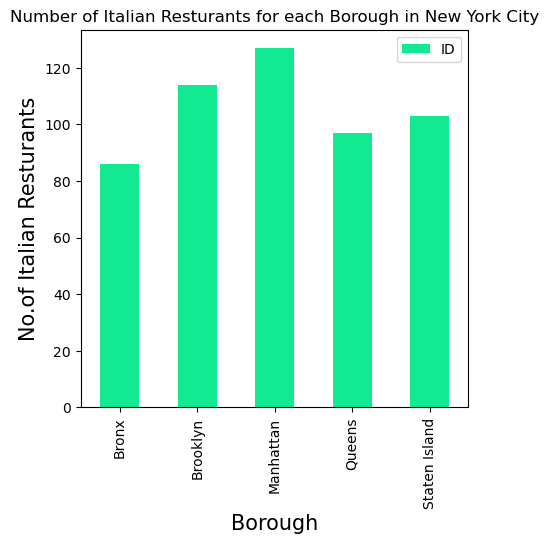

In [20]:
#Let's visualize the number of italian restaurants in each borough in NYC

plt.figure(figsize=(5,5), dpi = 100)
# title
plt.title('Number of Italian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar', color='#12EA92')
#legend
plt.legend()
#displays the plot
plt.show()

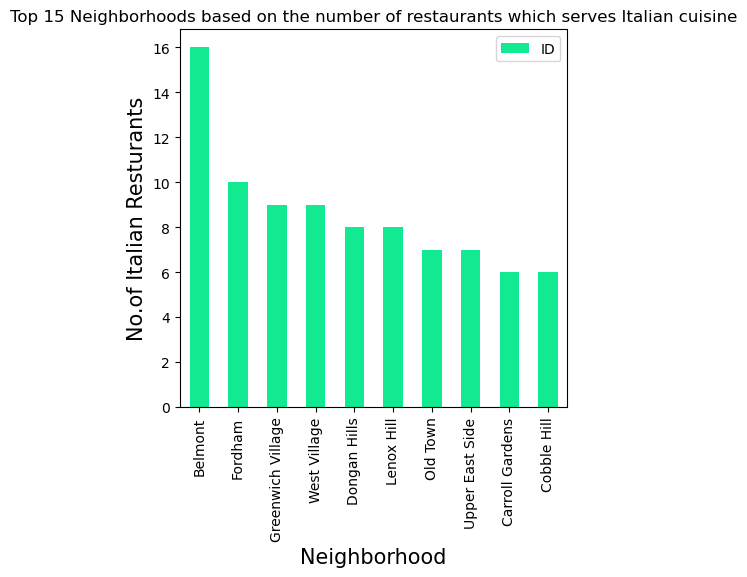

In [21]:

plt.figure(figsize=(5,5), dpi = 100)
# title
plt.title('Top 15 Neighborhoods based on the number of restaurants which serves Italian cuisine')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar', color='#12EA92')
#legend
plt.legend()
#displays the plot
plt.show()

Looks like Belmont is Neighborhood with the highest number of Italian Restaurants in New York City.

In [22]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
45,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
46,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
47,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
48,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
49,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
50,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
51,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
52,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
53,Bronx,Belmont,4aa193d5f964a520124120e3,Mario's Restaurant & Catering
54,Bronx,Belmont,4a8e261cf964a5201c1220e3,Roberto's


At this point, we can acquire detail about restaurants from the Foursqare API. 

In [23]:
# Beginning by prepare neighborhood list that contains italian resturants

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

  
0     6.9    12  
( 371 / 527 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5b1b7633c03635002c5e8d93
( 372 / 527 ) processed
                         ID        Name  Likes  Rating  Tips
0  4b9a599af964a5201aae35e3  Cucina Mia      5     7.0     3
( 373 / 527 ) processed
                         ID        Name  Likes  Rating  Tips
0  4e35b9daaeb7f67fbd346ef9  Waterfalls      7     5.9    25
( 374 / 527 ) processed
                         ID               Name  Likes  Rating  Tips
0  4ad910d8f964a520b81721e3  Da Noi Restaraunt     13     7.6     6
( 375 / 527 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b343839f964a5203a2625e3  La Strada     24     7.9    10
( 376 / 527 ) processed
                         ID    Name  Likes  Rating  Tips
0  4be61580d4f7c9b6fe662620  Brioso     22     7.6    15
( 377 / 527 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4bc73

KeyError: 'venue'

In [26]:
italian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.2,14
3,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.4,6
4,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden,26,7.4,8


In [27]:
italian_rest_stats_ny.shape

(500, 7)

In [28]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       500 non-null    object 
 1   Neighborhood  500 non-null    object 
 2   ID            500 non-null    object 
 3   Name          500 non-null    object 
 4   Likes         500 non-null    object 
 5   Rating        500 non-null    float64
 6   Tips          500 non-null    object 
dtypes: float64(1), object(6)
memory usage: 27.5+ KB


In [29]:
convert_types = { 'Likes': float, 'Tips': float }
italian_rest_stats_ny = italian_rest_stats_ny.astype(convert_types)
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       500 non-null    object 
 1   Neighborhood  500 non-null    object 
 2   ID            500 non-null    object 
 3   Name          500 non-null    object 
 4   Likes         500 non-null    float64
 5   Rating        500 non-null    float64
 6   Tips          500 non-null    float64
dtypes: float64(3), object(4)
memory usage: 27.5+ KB


<h3> Restaurant with most tips

In [30]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 22
Rating                               8.4
Tips                                1136
Name: 367, dtype: object

<h3> Most rated restaurant

In [31]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              5a00f3538496ca58fd9e2856
Name                  Evelina Restaurant
Likes                                207
Rating                               9.4
Tips                                  37
Name: 126, dtype: object

<h3>Most Liked Restaurant

In [32]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2503
Rating                               9.3
Tips                                 831
Name: 238, dtype: object

Let's create now a data set containing the average rating about all the restaurant in each neighborhood in NYC.

In [33]:
ny_neighborhood_stats = italian_rest_stats_ny.groupby('Neighborhood', as_index = False).mean()[['Neighborhood', 'Rating']]
ny_neighborhood_stats.columns = ['Neighborhood', 'Average Rating']

<h3> We now list the <i>Top 10 neighborhoods</i> ordered by average rating of Italian restaurants. 

In [35]:
ny_neighborhood_stats.sort_values(['Average Rating'], ascending=False).head(10)

,Neighborhood,Average Rating
23,Bushwick,9.300000
91,Little Italy,9.100000
27,Central Harlem,9.100000
54,Emerson Hill,9.100000
45,Downtown,9.100000
20,Boerum Hill,9.100000
12,Bedford Stuyvesant,9.100000
77,Greenwich Village,9.088889
168,West Village,9.011111
114,Noho,9.000000


Extending to Borough:

In [36]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough', as_index=False).mean()[['Borough', 'Rating']]
ny_borough_stats.columns=['Borough', 'Average Rating']
ny_borough_stats.sort_values(['Average Rating'], ascending=False).head(10)

,Borough,Average Rating
2,Manhattan,8.630081
1,Brooklyn,7.645283
0,Bronx,7.451852
3,Queens,7.212903
4,Staten Island,6.423711


Let's visualize now results by usign a <b>Bar chart</b>

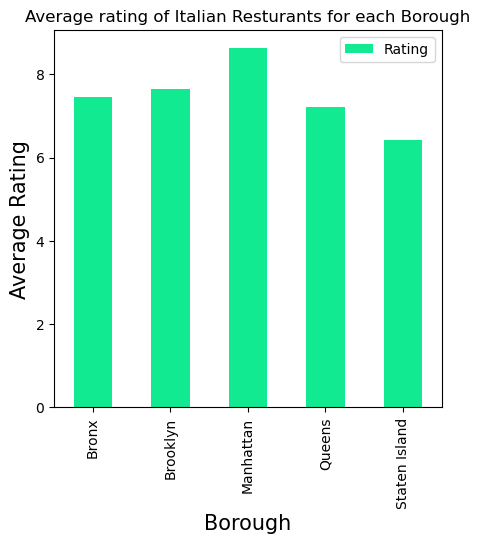

In [37]:
plt.figure(figsize=(5,5), dpi = 100)
# title
plt.title('Average rating of Italian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color='#12EA92')
#legend
plt.legend()
#displays the plot
plt.show()

At this poin, would be useful to list neighborhoods with average rating greater than or equal to 9. 

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
12,Bedford Stuyvesant,9.100000
20,Boerum Hill,9.100000
23,Bushwick,9.300000
27,Central Harlem,9.100000
31,Civic Center,9.000000
45,Downtown,9.100000
54,Emerson Hill,9.100000
77,Greenwich Village,9.088889
78,Hamilton Heights,9.000000
84,Jackson Heights,9.000000


In [39]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,df_ny, on='Neighborhood')

In [40]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,9.100000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,9.100000
2,Brooklyn,Bushwick,40.698116,-73.925258,9.300000
3,Manhattan,Central Harlem,40.815976,-73.943211,9.100000
4,Manhattan,Civic Center,40.715229,-74.005415,9.000000
5,Brooklyn,Downtown,40.690844,-73.983463,9.100000
6,Staten Island,Emerson Hill,40.606794,-74.097762,9.100000
7,Manhattan,Greenwich Village,40.726933,-73.999914,9.088889
8,Manhattan,Hamilton Heights,40.823604,-73.949688,9.000000
9,Queens,Jackson Heights,40.751981,-73.882821,9.000000


<h3> Visualization of Results :

In [41]:
ny_map= folium.Map(location=geo_location('New York'), zoom_start=12)

In [42]:
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='#EA1253',
            fill=True,
            fill_color='#12EA92',
            fill_opacity=0.4
        )
    )

In [43]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [44]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [51]:
#Choropleth map
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlGnBu',
    fill_opacity=0.6, 
    line_opacity=0.4,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('rated-map.html')